In [11]:
import sys
!{sys.executable} -m pip install pandas pandas_ta yfinance numpy matplotlib dataclasses datetime statsmodels pandas_market_calendars stockstats tabulate mplfinance hurst finta sklearn scipy
#!~/miniconda3/bin/conda install -c ranaroussi yfinance -y

  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached DateTime-4.3-py2.py3-none-any.whl (60 kB)


In [21]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date


import re
import time
import stat
import contextlib
import functools

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

#from fbprophet import Prophet
import urllib
import urllib.request
import pandas_market_calendars as mcal
import os.path
from os import path
from functools import reduce
#import pandas-datareader
#import mpl-finance
#from fbprophet.diagnostics import cross_validation
#rom fbprophet import Prophet
import stockstats
from stockstats import StockDataFrame
import tabulate
import mplfinance as mpf
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc

import os.path
from os import path

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

from finta import TA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [12]:
n_forward = 4

#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)

#- timedelta(weeks=w*2)
start_date = end_date1 - timedelta(weeks=w)

benchName = "^GSPC"
bench = yf.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date
benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)


In [13]:

dateindex = benchData.loc[start_date:end_date].index
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+5))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

nyse = mcal.get_calendar('NYSE')

nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+3)))



In [14]:
#if(len(data)==len(dateindex_)):
if(len(benchData)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0)
    frequency = pd.to_datetime(frequency, errors='coerce',format='%Y-%m-%d').index
    
else:
    frequency=nyse_trading_dates.rename_axis([None]).index
    


In [15]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)
df = df.interpolate(method='linear')
benchData = df[start_date:end_date]


In [16]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

In [44]:
pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

one_week_end = start_date
one_week_start = one_week_end - timedelta(weeks=1)

#need to do the two pass trick (i.e. find stocks fully populated a week 9 quarters back)

nyse = mcal.get_calendar('NYSE')
official_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date)

date_time_obj_start = start_date

date_time_obj_end = end_date

one_week_trading_dates = nyse.schedule(start_date=one_week_start, end_date=one_week_end)

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

#should turn this into a function
if path.exists("nasdaqtraded.txt"):
    print("file exists")
    
    filePath = 'nasdaqtraded.txt'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading")
        urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
        urllib.request.urlretrieve(url, 'mfundslist.txt')
        urllib.request.urlretrieve(url, 'bonds.txt')
    else:
      print("equal dates, not redownloading")
    
else:
    print("downloading nasdaqtraded.txt")
    urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
    urllib.request.urlretrieve(url, 'mfundslist.txt')
    urllib.request.urlretrieve(url, 'bonds.txt')
    
df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#process symbols for bad characters
BAD_CHARS = ['$','.']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df1 = df1[~df1['Symbol'].str.contains(pat)]
df2 = df2[~df2['Symbol'].str.contains(pat)]
df3 = df3[~df3['Symbol'].str.contains(pat)]

#choose size
size=300
#stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(df1["Symbol"].sample(n=int(size)))
mfunds = list(df2["Symbol"].sample(n=int(size/3)))
bonds = list(df3["Symbol"].sample(n=int(size/3)))
#symbols = unique(stocks + mfunds + bonds)
symbols = unique(stocks)

def dl_one_week(stock):
    subset = yf.download(stock, start=one_week_start, end=one_week_end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[one_week_start.strftime('%Y-%m-%d'):one_week_end.strftime('%Y-%m-%d')]
    if len(subset) != 0:
        return (subset)

def dl(stock):
    subset = yf.download(stock, start=start_date, end=end_date+timedelta(days=1), auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    subset2 = subset[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)

def processStocks(symbols):

    futures1 = [pool1.submit(dl_one_week, args) for args in symbols]
    wait(futures1, timeout=None, return_when=ALL_COMPLETED)

    symbols_data_one_week = pd.DataFrame()

    for x in range(0,len(symbols)):
        prices = pd.DataFrame(futures1[x].result())
        prices['Symbol'] = symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        symbols_data_one_week = pd.concat([symbols_data_one_week,prices])

    #symbols_data_one_week

    #stocks that existed 9 quarters ago
    vetted_symbols = list(symbols_data_one_week.Symbol.unique())

    pool2 = concurrent.futures.ProcessPoolExecutor(cores)

    futures2 = [pool2.submit(dl, args) for args in vetted_symbols]
    wait(futures2, timeout=None, return_when=ALL_COMPLETED)    

    symbols_data = pd.DataFrame()
    
    #Have to interpolate later
    for x in range(0,len(vetted_symbols)):
        prices = pd.DataFrame(futures2[x].result())
        prices['Symbol'] = vetted_symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        #idx1 = prices.index  
        
        #df = prices.rename_axis([None]).reindex(frequency)

        #for d in prices.rename_axis([None]).index:
            #df.loc[d] = prices.loc[d]

        #df.interpolate(method='linear')
        
        #merged = idx1.union(frequency)
        #s = prices.reindex(merged)
        #df = s.interpolate().dropna(axis=0, how='any')

        #if len(df) == len(prices.index):
        symbols_data = pd.concat([symbols_data,prices])
            
    symbols_data.to_csv('symbols_data.csv', index = False)

if path.exists('symbols_data.csv'):
    print("data exists")
    
    filePath = 'symbols_data.csv'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading stocks")
        
        processStocks(symbols)
        
    else:
        print("equal dates, not redownloading")
    
else:
    print("downloading symbols")
    processStocks(symbols)
    
def get_signal(data, high, low):
    buy_signal = [] #The stock was over sold
    sell_signal = [] #The stock was over bought
    for i in range(len(data['MFI'])):
        if data['MFI'][i] > high: #Then the stock is over bought, you should sell 
          buy_signal.append(np.nan)
          sell_signal.append(data['Close'][i])
        elif data['MFI'][i] < low: #Then the stock is over sold, you should buy
          buy_signal.append(data['Close'][i])
          sell_signal.append(np.nan)
        else:
          buy_signal.append(np.nan)
          sell_signal.append(np.nan)
    return (buy_signal, sell_signal)    


#weighted moving average
def atrVolume(df, n=50):
    #data = df.copy()
    high = df['High']*df['Volume']
    low = df['Low']*df['Volume']
    close = df['Close']*df['Volume']
    data = pd.DataFrame()
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

sdev_constant = 2.0

def bbands(df, n=20):
    #data = df.copy()
    high = df['High']*df['Volume']
    low = df['Low']*df['Volume']
    #close = data['close']
    data = pd.DataFrame()
    upper_band = ta.ema(high, length=n)
    lower_band = ta.ema(low, length=n)
    upper_sdev = np.std(upper_band)
    lower_sdev = np.std(upper_band)
    data['bbands_upper'] = upper_band + upper_sdev * sdev_constant
    data['bbands_lower'] = lower_band - lower_sdev * sdev_constant
    return data

def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()


file exists
Last Modified Time :  Tue Mar 30 00:06:44 2021
equal dates, not redownloading
data exists
Last Modified Time :  Tue Mar 30 00:07:04 2021
equal dates, not redownloading


/root/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [18]:
#symbols = ['BTC-USD']
#processStocks(symbols)

symbols_data = pd.read_csv('symbols_data.csv', sep=',')[0:-1]
vetted_symbols = symbols_data.Symbol.unique()


In [19]:
returnsdf = pd.DataFrame()
returnsl = []

#cumulative returns of 1st half
for i in vetted_symbols:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    #plt.plot(cumulative_ret, label=i)
    #plt.legend(loc="upper left",fontsize=8)
    
returnsdf["returns"] = returnsl
returnsdf["stock"] = vetted_symbols

returnsdf = returnsdf.sort_values(by=['returns'], ascending=False)

XPercent = .1
cutoff = round(len(returnsdf)*XPercent,0)

topXPercent = returnsdf['stock'][0:int(cutoff)]
topXPercent

94     QNST
146    BOOM
73     NBEV
95     ENTA
149      BA
97     TCMD
136       W
130    NTIC
69     ADBE
163    TREX
46      CME
13     CTEK
110    AUPH
83     WLDN
175    MSFT
139      DE
158    AZPN
88     OTRK
Name: stock, dtype: object

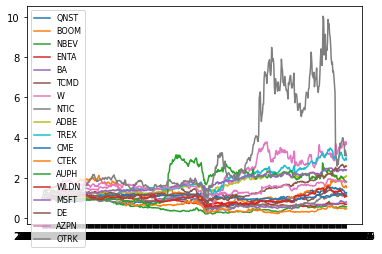

In [20]:
#cumulative returns over test period

for i in topXPercent:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    plt.plot(cumulative_ret, label=i)
    plt.legend(loc="upper left",fontsize=8)
    #plt.xticks(rotation=30) 

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

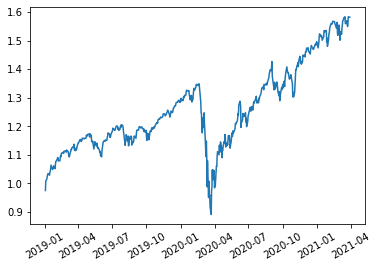

In [22]:
limit = 100

train_size = 0.5

#minExpectedReturn = 0.0005
minExpectedReturn = 0.0

#width1 = len(nyse_trading_dates[start_date:end_date1].index)

#not doing any sales here, so is the +1 necessary?
#even if doing +1 I don't want to use timedelta, but it's okay to use it becuase at most it's +1 actual day (vs trading day) and the filtering will still work
#width2 = len(data.loc[end_date1+timedelta(days=1):end_date].index)
width2 = len(nyse_trading_dates[end_date1+timedelta(days=1):end_date].index)


#dateindex = benchData.loc[start_date:end_date].index
#returnsdf[0:int(cutoff)]

dateindex = benchData.loc[start_date:end_date].index
dateindex_ = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date)-start_date).days)]
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

sp500_data = benchData[end_date1+timedelta(days=1):end_date]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.xticks(rotation=30) 

In [46]:
#for symbol in [topXPercent.iloc[1]]:
def processSets(symbol):

    subset = symbols_data[symbols_data["Symbol"]==symbol].dropna().copy()    
    
    #print(subset)
    subset = subset.set_index('Date')
    width1 = len(subset[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')])
    
    subset['VWP'] = subset['Close']*subset['Volume']
    
    Short_EVWMA = pd.DataFrame(TA.EVWMA(subset,12))
    Long_EVWMA = pd.DataFrame(TA.EVWMA(subset,26))
    Short_EVWMA.columns = ['EVWMA_12']
    Long_EVWMA.columns = ['EVWMA_26']

    #p 209 of ttr doc
    MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/Long_EVWMA['EVWMA_26'])
    MACD_EVWMA.columns = ['MACD-line']

    Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
    Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
    subset['MACD_Signal'] = Signal_EVWMA
        
    #will help later with bad data during loops

    prices = subset.loc[~subset.index.duplicated(keep='last')]        
    df = prices.reindex(pd.DataFrame(frequency).set_index(0)[start_date:end_date].index)

    for d in prices.rename_axis([None]).index:
        df.loc[d] = prices.loc[d]

    df['Volume'] = df['Volume'].replace('0', np.NaN).interpolate(method='time')
    df.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d')

    df = df.interpolate(method='time')

    #conditions_ = []

    typical_price = (df['Close'] + df['High'] + df['Low']) /3
    
    period = 14
    
    money_flow = typical_price * df['Volume']
    
    positive_flow =[] #Create a empty list called positive flow
    negative_flow = [] #Create a empty list called negative flow
    
    #Loop through the typical price 
    for i in range(0, len(typical_price)):
      if typical_price[i] > typical_price[i-1]: #if the present typical price is greater than yesterdays typical price
        positive_flow.append(money_flow[i-1])# Then append money flow at position i-1 to the positive flow list
        negative_flow.append(0) #Append 0 to the negative flow list
      elif typical_price[i] < typical_price[i-1]:#if the present typical price is less than yesterdays typical price
        negative_flow.append(money_flow[i-1])# Then append money flow at position i-1 to negative flow list
        positive_flow.append(0)#Append 0 to the positive flow list
      else: #Append 0 if the present typical price is equal to yesterdays typical price
        positive_flow.append(0)
        negative_flow.append(0)
        
    positive_mf =[]
    negative_mf = [] 
    #Get all of the positive money flows within the time period
    for i in range(0, len(positive_flow)):
      positive_mf.append(sum(positive_flow[0 : i+1]))
    #Get all of the negative money flows within the time period  
    for i in range(0, len(negative_flow)):
      negative_mf.append(sum(negative_flow[0 : i+1]))
        
    mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf) ))
    
    df['MFI'] = mfi
    df[['bbands_upper', 'bbands_lower']] = bbands(df)
    df['ATR'] = atrVolume(df)

    #subset['Buy'] = get_signal(subset, 80, 20)[0]
    #subset['Sell'] = get_signal(subset, 80, 20)[1]
    #Show the new dataframe
    
    return df
pool3 = concurrent.futures.ProcessPoolExecutor(cores)

futures3 = [pool3.submit(processSets, args) for args in topXPercent]

wait(futures3, timeout=None, return_when=ALL_COMPLETED)



DoneAndNotDoneFutures(done={<Future at 0x7fee71b33640 state=finished returned DataFrame>, <Future at 0x7fee71b33850 state=finished returned DataFrame>, <Future at 0x7fee71b33a60 state=finished returned DataFrame>, <Future at 0x7fee71b33e50 state=finished returned DataFrame>, <Future at 0x7fee71a1ec40 state=finished returned DataFrame>, <Future at 0x7fee71b33ca0 state=finished returned DataFrame>, <Future at 0x7fee71b33ac0 state=finished returned DataFrame>, <Future at 0x7fee711dd4c0 state=finished returned DataFrame>, <Future at 0x7fee71b33ee0 state=finished returned DataFrame>, <Future at 0x7fee71a1e2e0 state=finished returned DataFrame>, <Future at 0x7fee71b339d0 state=finished returned DataFrame>, <Future at 0x7fee71b33100 state=finished returned DataFrame>, <Future at 0x7fee71b33d00 state=finished returned DataFrame>, <Future at 0x7fee71a1edf0 state=finished returned DataFrame>, <Future at 0x7fee71a1e550 state=finished returned DataFrame>, <Future at 0x7fee71b33760 state=finished r

In [153]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'VWP', 'MACD_Signal', 'MFI',
       'bbands_upper', 'bbands_lower', 'ATR', 'Price_Up'],
      dtype='object')

In [185]:
scores = []

for f in range(0,len(futures3)):
    #print(f)
    #print(len(futures3[f].result()))
    #print(futures3[f].result())
    df = futures3[f].result()
    remove_list = ['Symbol'] 
    #remove_list = ['Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWP', 'MACD_Signal', 'MFI','bbands_upper', 'bbands_lower', 'ATR', 'Price_Up']
    df = df.drop(columns=remove_list)
    df = df.dropna()
    #Manipulate the data set 
    #Create the target column
    df['Price_Up'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0) # if tomorrows price is greater than todays price put 1 else put 0
    #Remove the date column
    #remove_list = ['date'] 
    #df = df.drop(columns=remove_list)
    
    #Split the data set into a feature or independent data set (X) and a target or dependent data set (Y)
    X = df.iloc[:, 0:df.shape[1] -1].values #Get all the rows and columns except for the target column
    Y = df.iloc[:, df.shape[1]-1].values  #Get all the rows from the target column
    
    #Split the data again but this time into 80% training and 20% testing data sets
    #https://stackoverflow.com/questions/35472712/how-to-split-data-on-balanced-training-set-and-test-set-on-sklearn
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0, stratify=Y)    
    
    #Create and train the decision tree Classifier model
    tree = DecisionTreeClassifier().fit(X_train, Y_train)
    #Check how well the model did on the training data set
    #print( tree.score(X_train, Y_train))
    
    #Check how well the model did on the test data set
    scores.append(tree.score(X_test, Y_test))
    #print( tree.score(X_test, Y_test))
    
    #Show the model tree predictions
    tree_prediction = tree.predict(X_test)
    #print( tree_prediction )
    
    #Show the actual values from the test data set
    #Y_test
    
sum(scores)/len(scores)

0.5100644122383253

0.5138260432378079